In [3]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [130]:
data = pd.read_csv('./time_series3.csv',delimiter='\t')
data.head()

,1,2,3,4,5
0,-0.979234,-1.416973,-0.489459,-1.729622,-0.134724
1,-1.299158,-1.113212,-0.632251,-1.737313,-0.248217
2,-1.376446,-1.950953,-1.086232,-0.829957,-0.726847
3,-1.411108,-2.811393,-1.302569,-1.132002,0.212635
4,-1.609624,-2.773193,-0.696774,-1.382566,-0.250348


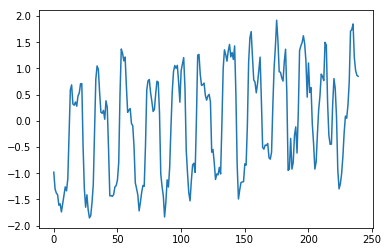

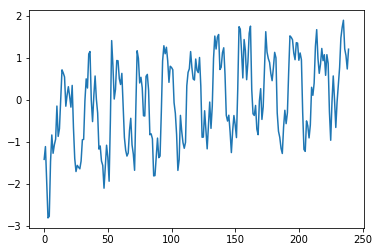

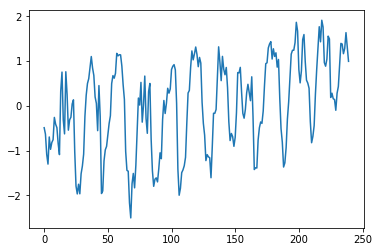

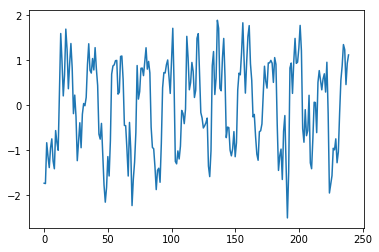

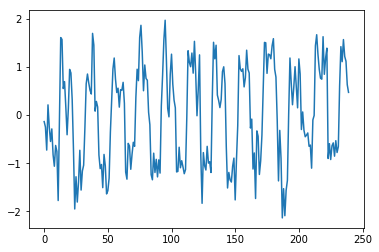

In [131]:
for i in data.columns:
    data[i].plot()
    plt.show()

In [132]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np

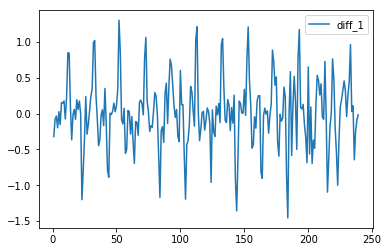

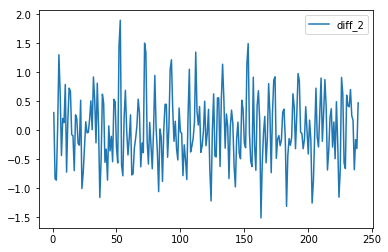

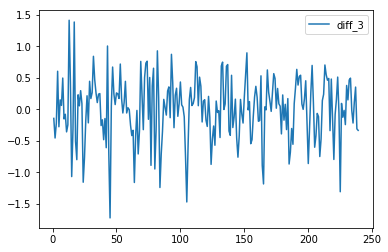

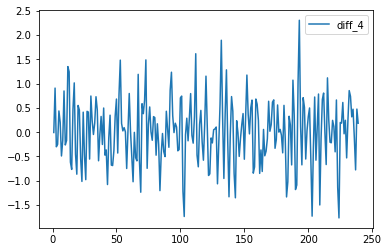

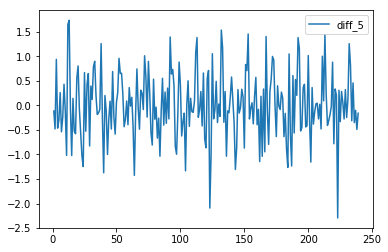

In [134]:
for i in data.columns[:5]:
    data['diff_'+i] = data[i].diff()
    data[['diff_'+i]].plot()
    plt.show()

In [152]:
diff_col = [i for i in data.columns if i.startswith('diff') ]

sc_data = data[diff_col].iloc[1:, :]

mms = MinMaxScaler(feature_range=(-1, 1))
sc_data = mms.fit_transform(sc_data)

print(sc_data.shape)
print(sc_data)

(239, 5)
[[-1.76300443e-01  6.55151876e-02  6.87125298e-03 -1.35802214e-01
   8.17985093e-02]
 [-6.06484721e-04 -6.04309925e-01 -1.91436941e-01  3.13528629e-01
  -9.94469824e-02]
 [ 3.02589223e-02 -6.17629541e-01 -3.99956199e-02 -2.80344226e-01
   6.04472229e-01]
 ...
 [-1.21847446e-01 -2.07536954e-01  3.23715404e-01 -5.13997090e-01
   8.88194277e-02]
 [-1.03662235e-02 -2.99149927e-01 -9.87982151e-02  1.01193854e-01
  -1.04376052e-01]
 [ 4.26125496e-02  1.63733824e-01 -1.14183252e-01 -4.20273854e-02
   5.91488339e-02]]


In [145]:
# train_size = len(sc_data) - 12
# test_size = len(sc_data) - train_size
# print(len(sc_data), train_size, test_size)

# train, test = sc_data[0:train_size,:], sc_data[train_size:len(sc_data),:]

In [104]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
        
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[:-1, :]
    
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [176]:
lag = 5
X = np.array([]).reshape(0,5)
y = np.array([])
for i in range(sc_data.shape[1]):
    X_i, y_i = create_data(sc_data[:,i],lag)
    X = np.concatenate((X,X_i),axis=0)
    y = np.concatenate((y,y_i),axis=0)
    
print(X.shape)
print(y.shape)

(1170, 5)
(1170,)


In [105]:
# lag = 5
# train_X, train_Y = create_data(train, lag)
# test_X, test_Y = create_data(test, lag)


In [106]:
# # reshape input to be [samples, time steps, features]
# train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
# test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [177]:
# print(train_X.shape, train_Y.shape)

In [178]:
# reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [186]:
np.random.seed(42)

batch_size = 1
model = Sequential()
model.add(LSTM(4, 
               batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
               stateful=True))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (1, 4)                    96        
_________________________________________________________________
dense_10 (Dense)             (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [187]:
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(20):
    model.fit(X, y, #validation_data=(test_X, test_Y), 
              epochs=3, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Epoch 1/3
1170/1170 [==============================] - 6s 5ms/step - loss: 0.1176
Epoch 2/3
1170/1170 [==============================] - 4s 4ms/step - loss: 0.1163
Epoch 3/3
1170/1170 [==============================] - 4s 4ms/step - loss: 0.1159
Epoch 1/3
1170/1170 [==============================] - 4s 3ms/step - loss: 0.1156
Epoch 2/3
1170/1170 [==============================] - 6s 5ms/step - loss: 0.1154
Epoch 3/3
1170/1170 [==============================] - 5s 4ms/step - loss: 0.1151
Epoch 1/3
1170/1170 [==============================] - 4s 3ms/step - loss: 0.1148
Epoch 2/3
1170/1170 [==============================] - 4s 3ms/step - loss: 0.1144
Epoch 3/3
1170/1170 [==============================] - 4s 3ms/step - loss: 0.1139
Epoch 1/3
1170/1170 [==============================] - 4s 3ms/step - loss: 0.1131
Epoch 2/3
1170/1170 [==============================] - 5s 4ms/step - loss: 0.1118
Epoch 3/3
1170/1170 [==============================] - 4s 4ms/step - loss: 0.1094
Epoch 1/3
1170/1

MAE =  0.21477298568223463


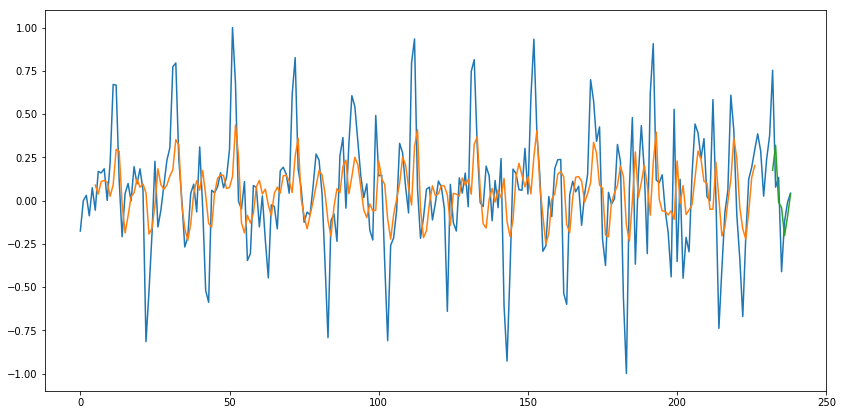

In [112]:
from sklearn.metrics import mean_absolute_error

train_predict = model.predict(train_X, batch_size=batch_size)
test_predict = model.predict(test_X, batch_size=batch_size)
test_observed = sc_data[-len(test_predict):, :]

print('MAE = ', mean_absolute_error(test_observed, test_predict))

# shift train predictions for plotting
train_predict_plot = np.empty_like(sc_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(sc_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_predict):, :] = test_predict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(sc_data)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [114]:
# diffed then scaled
predictions = np.empty_like(data.value.values)

n_test = len(test_predict)
predictions[-n_test-1] = data.value.values[-n_test-1]
predictions[-n_test:] = data.value.values[-n_test-1:-1]+mms.inverse_transform(test_predict).flatten()

dates = data.index
plt.plot(dates[-n_test-5:], data.value.values[-n_test-5:])
plt.plot(dates[-n_test-1:], predictions[-n_test-1:])

AttributeError: 'DataFrame' object has no attribute 'value'